In [2]:
import numpy as np
import torch
from torchvision import transforms
from compressai.zoo import (
    bmshj2018_factorized,
    bmshj2018_hyperprior,
    mbt2018_mean,
    mbt2018,
    cheng2020_anchor,
)
import numpy as np
import argparse
from diffusers import DiffusionPipeline
from abc import ABC, abstractmethod
from PIL import Image
import os
from copy import deepcopy
from glob import glob
from PIL import Image
import random
# Set a new cache directory
os.environ["TORCH_HOME"] = "~/.cache_new"

## Regeneration attack

In [15]:
class generativeAttacks(ABC):
    @abstractmethod
    def attack(self, image):
        pass

class VAEAttack(generativeAttacks):
    def __init__(self, model=[], quality=1, metric="mse"):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = []
        for m in model:
            print(f"Loading {m} model")
            match m:
                case "bmshj2018_factorized":
                    self.model.append(bmshj2018_factorized(quality=quality, metric=metric, pretrained=True).eval().to(self.device))
                case "bmshj2018_hyperprior":
                    self.model.append(bmshj2018_hyperprior(quality=quality, metric=metric, pretrained=True).eval().to(self.device))
                case "mbt2018_mean":
                    self.model.append(mbt2018_mean(quality=quality, metric=metric, pretrained=True).eval().to(self.device))
                case "mbt2018":
                    self.model.append(mbt2018(quality=quality, metric=metric, pretrained=True).eval().to(self.device))
                case "cheng2020_anchor":
                    self.model.append(cheng2020_anchor(quality=quality, metric=metric, pretrained=True).eval().to(self.device))
                case _:
                    raise Exception("Invalid model name")

    def attack(self, image: Image.Image, preprocess=True):
        # Preprocess: convert to RGB from BGR
        if preprocess:
            image = image.convert("RGB")
            image = image.resize((512, 512))
            image = transforms.ToTensor()(image).unsqueeze(0).to(self.device)
            result = []
        for model in self.model:
            with torch.no_grad():
                out = model(image)
                out["x_hat"].clamp_(0, 1)
                result.append(transforms.ToPILImage()(out["x_hat"].squeeze().cpu()) if preprocess else out)
        return result

class DiffuserAttack:
    def __init__(self, model="stabilityai/stable-diffusion-xl-refiner-1.0"):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.pipeline = DiffusionPipeline.from_pretrained(model
    , torch_dtype=torch.float16, variant="fp16", use_safetensors=True, 
).to(self.device)

    def attack(self, image: Image.Image, regen=1, prompt=""):
        res = deepcopy(image).convert("RGB")
        for iter in range(regen):
            res = self.pipeline(prompt, image=res).images[0]
        return res

### Test the regeneration attack: VAE

In [4]:
# paths
image_path = glob('/ephemeral/yaya/projects/watermark-analysis/data/Neurips24_ETI_BeigeBox/**/*.png', recursive=True)
# open image
image = Image.open(random.choice(image_path))
# attack
vaes = ["bmshj2018_factorized", "bmshj2018_hyperprior", "mbt2018_mean", "mbt2018", "cheng2020_anchor"]
# vae
attack = VAEAttack(model=vaes,quality=5)
result = attack.attack(image)

Loading bmshj2018_factorized model
Loading bmshj2018_hyperprior model
Loading mbt2018_mean model


Loading mbt2018 model
Loading cheng2020_anchor model


/ephemeral/yaya/anaconda3/envs/watermark/lib/python3.10/site-packages/compressai/entropy_models/entropy_models.py:633: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /ephemeral/yaya/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at ../aten/src/ATen/native/cuda/jit_utils.cpp:1442.)
  return half * torch.erfc(const * inputs)


Matplotlib created a temporary cache directory at /tmp/matplotlib-ir9kr8ia because the default path (/ephemeral/yaya/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


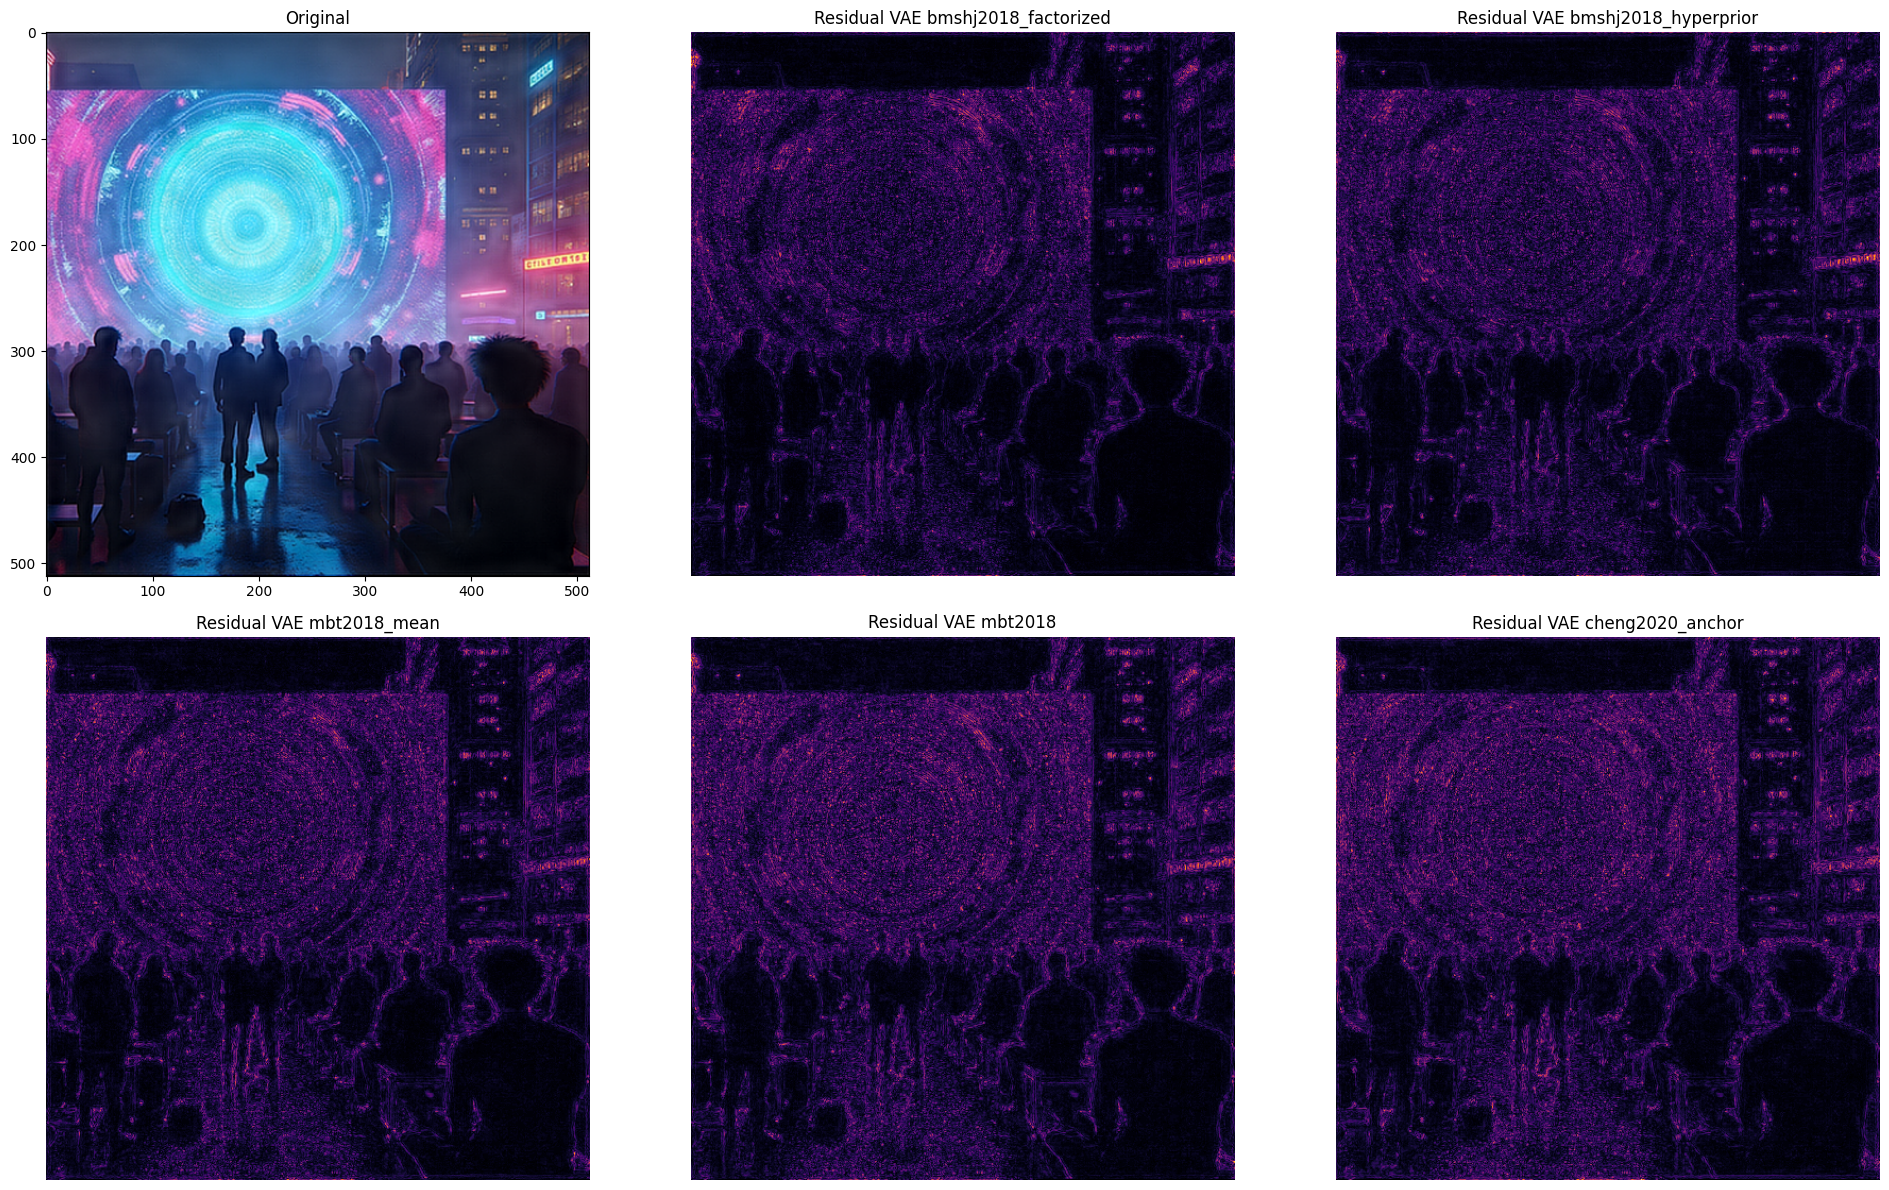

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the figure
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs[0][0].imshow(image)
axs[0][0].set_title("Original")

# Convert the original image to a NumPy array
original_array = np.asarray(image).astype(np.float32)

for i, model in enumerate(result):
    # Convert the model's output to a NumPy array
    model_array = np.asarray(model).astype(np.float32)
    
    # Compute the residual
    residual = np.abs(original_array - model_array)    
    # Normalize the residual for visualization (0-255 range)
    # take channels mean
    residual = residual.max(axis=-1)
    residual_normalized = (255 * (residual - residual.min()) / (residual.max() - residual.min())).astype(np.uint8)
    # Plot the residual using a "hot" colormap
    axs[(i + 1) // 3][(i + 1) % 3].imshow(residual_normalized, cmap="inferno")
    axs[(i + 1) // 3][(i + 1) % 3].set_title(f"Residual VAE {vaes[i]}")
    axs[(i + 1) // 3][(i + 1) % 3].axis("off")  # Optional: turn off axes for a cleaner look

plt.tight_layout()
plt.show()


### Test the regeneration attack: Diffusion

In [18]:
image = Image.open(random.choice(image_path))
diffusion_attack = DiffuserAttack()
result = diffusion_attack.attack(image, regen=4)

100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


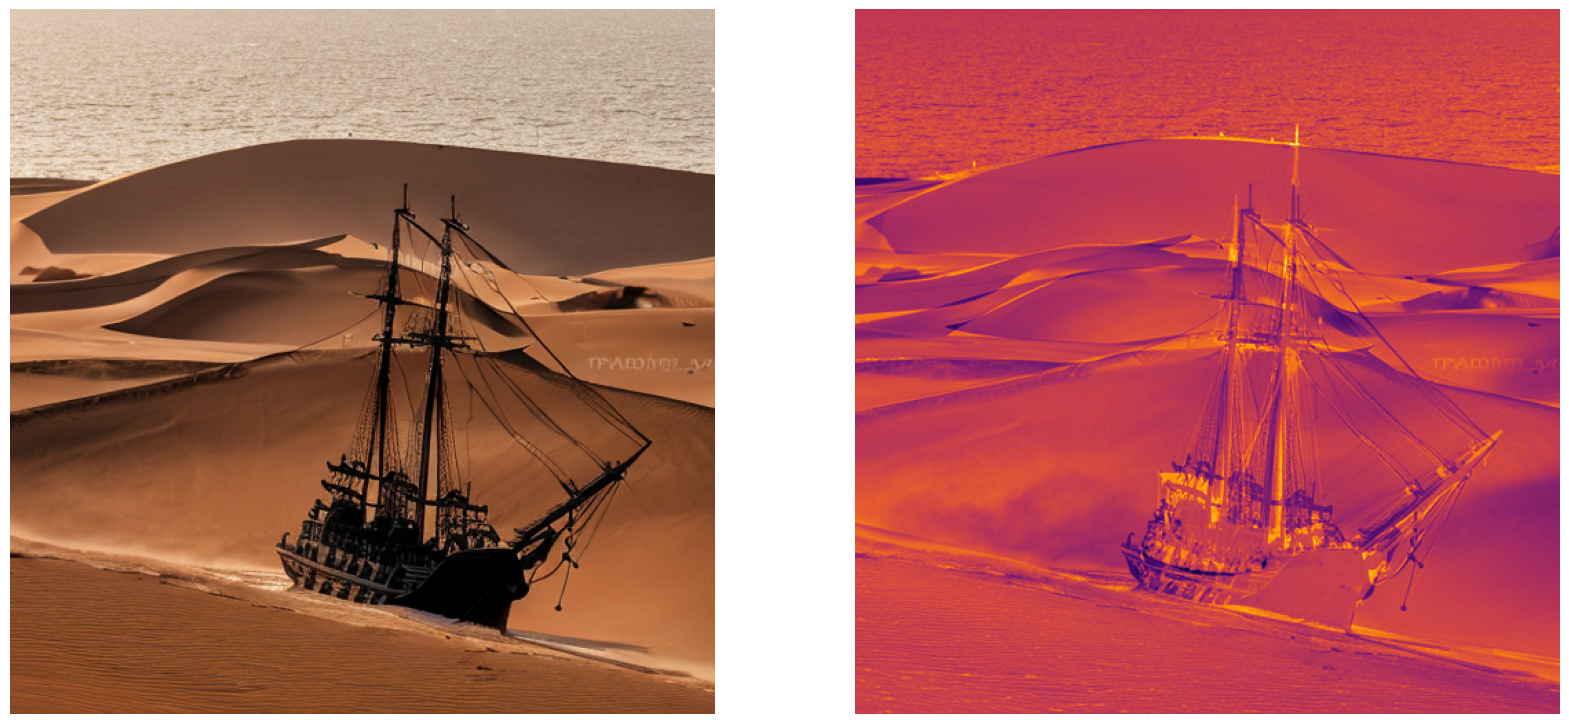

In [19]:
# Calculate residual (difference between initial image and result)
residual = np.array(image, dtype=np.float32) - np.array(result, dtype=np.float32)

# Take mean across color channels to convert to one channel (grayscale)
residual_gray = np.mean(residual, axis=2)

# Normalize the residual to 0-255 for better visualization
residual_normalized = 255 * (residual_gray - np.min(residual_gray)) / (np.max(residual_gray) - np.min(residual_gray))
residual_normalized = residual_normalized.astype(np.uint8)

# Plot the initial image and the residual
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(image)
ax[1].imshow(residual_normalized, cmap='inferno')
ax[0].axis("off")
ax[1].axis("off")
plt.show()